<h1 align="center">Trabalho 3 - Sistemas dinâmicos: ABS</h1>
<h3 align="center">Dezembro, 2021</h3>

Inês Pires Presa - A90355  
Tiago dos Santos Silva Peixoto Carriço - A91695

## Descrição do Problema

No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

## Autómato Híbrido
O seguinte autómato híbrido modela o comportamento de um ABS de um carro.

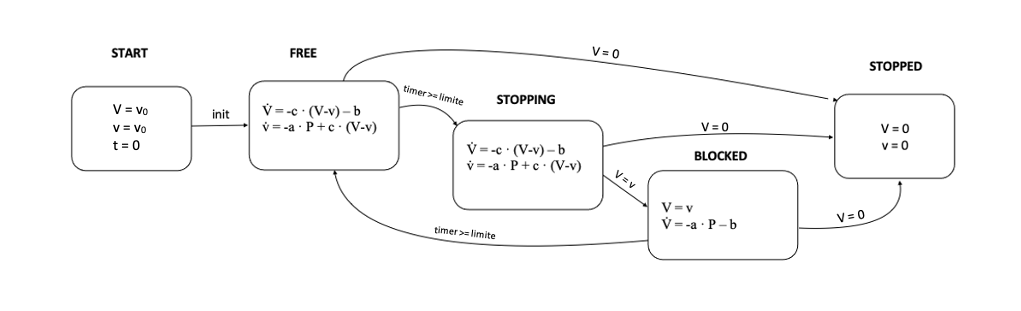

Inicialmente a velocidade (do carro - $V$, e das rodas - $v$) é de $v_{0} \space m/s$. Enquanto a velocidade é superior a 0, o carro encontra-se num ciclo entre os estados FREE, STOPPING e BLOCKED, transitando entre estes quando o timer atinge o seu limite, com exceção da transição de STOPPING para BLOCKED que é feita quando as velocidades do carro e das rodas se encontram.  

Variáveis cointínuas do autómato híbrido:
- $V$, que denota a velocidade do corpo  do veículo em relação ao solo
- $v$, que denota a velocidade linear das rodas em relação ao solo


Para além destas, inclui-se também as variáveis especiais:
- $t$, que denota o tempo
- $m$, que denota o *modo de funcionamento*
- $timer$, que denota o timer que impede que se permaneça em certos modos mais do que $\tau\,$segundos

Valores estipulados para as constantes:
- $limite\_timer$ - 0.1
- $a$ - 0.01
- $b$ - 0.5
- $c$ - 10 quando se encontra no estado STOPPING e 0.5 nos restantes
- $P$ - 1000
- $erro$ - para compensar os possíveis erros de falta de rigor nas fórmulas foi introduzida uma variável para garantir que estes não afetam o funcionamento do programa

## Descrição das transições

### Transições *untimed*
$$
m = \mathsf{START} \wedge m' = \mathsf{FREE}\wedge t' = t \wedge V' = V \wedge v' = v \wedge timer = 0 \wedge timer' = 0 \\
\vee\\
m = \mathsf{FREE} \wedge m' = \mathsf{STOPPING} \wedge t' = t \wedge V' = V \wedge v' = v \wedge timer \ge limite\_timer \wedge timer' = 0 \\
\vee\\
m = \mathsf{STOPPING} \wedge m' = \mathsf{BLOCKED} \wedge t' = t \wedge V' = V \wedge v' = v \wedge V - v \le erro \wedge timer' = 0 \\
\vee\\
m = \mathsf{BLOCKED} \wedge m' = \mathsf{FREE} \wedge t' = t \wedge V' = V \wedge v' = v \wedge timer \ge limite\_timer \wedge timer' = 0 \\
\vee\\
m = \mathsf{FREE} \wedge m' = \mathsf{STOPPED} \wedge t' = t \wedge V \le erro \wedge v \le erro \wedge V' = v' \wedge V' = 0 \wedge timer' = 0 \\
\vee\\
m = \mathsf{STOPPING} \wedge m' = \mathsf{STOPPED} \wedge t' = t \wedge V \le erro \wedge v \le erro \wedge V' = v' \wedge V' = 0 \wedge timer' = 0 \\
\vee\\
m = \mathsf{BLOCKED} \wedge m' = \mathsf{STOPPED} \wedge t' = t \wedge V \le erro \wedge v \le erro \wedge V' = v' \wedge V' = 0 \wedge timer' = 0 \\
\vee\\
m = \mathsf{STOPPED} \wedge m' = \mathsf{STOPPED} \wedge t' = t \wedge v' = v \wedge V' = V \wedge timer = 0 \wedge timer' = 0
$$
### Transições *timed*
$$
m = \mathsf{BLOCKED} \wedge m' = \mathsf{BLOCKED} \wedge t' \ge t \wedge timer' - timer = t' - t \wedge t' \le limite\_timer \wedge V \le v + erro \wedge V' \le v' + erro \wedge V' - V = (-a * P - b) * intervalo \wedge t' - t = intervalo \wedge v \le V \wedge v' \le V' \wedge V' \ge erro \wedge v' \ge erro \\
\vee\\
m = \mathsf{FREE} \wedge m' = \mathsf{FREE} \wedge t < t' \wedge timer' - timer = t' - t \wedge timer' \le limite\_timer \wedge V' - V = (-c * (V - v) - b) * intervalo \wedge v' - v = (-a * P + c * (V - v)) * intervalo \wedge t' - t = intervalo \wedge v \le V \wedge v' \le V' \wedge V' \ge erro \wedge v' \ge erro \\
\vee\\
m = \mathsf{STOPPING} \wedge m' = \mathsf{STOPPING} \wedge t \le t' \wedge timer = 0 \wedge timer' = 0 \wedge V' - V = (-c * (V-v) - b) * intervalo \wedge v' - v = (-a * P + c * (V - v)) * intervalo \wedge t' - t = intervalo \wedge V - v > erro \wedge v \le V \wedge v' \le V' $$

In [ ]:
!pip install z3-solver

In [ ]:
from z3 import *
import matplotlib.pyplot as plt


## Declaração do tipo enumerado para implementar os modos.

In [ ]:
Mode, (START, FREE, STOPPING, BLOCKED, STOPPED) = EnumSort('Mode', ('START', 'FREE', 'STOPPING', 'BLOCKED', 'STOPPED'))

## Declaração das variáveis do FOTS

In [ ]:
def declare(i):
  s = {}
  s['t'] = Real('t' + str(i))
  s['m'] = Const('m'+ str(i), Mode)
  s['V'] = Real('V' + str(i))
  s['v'] = Real('v' + str(i))
  s['timer'] = Real('timer' + str(i))
  return s

## Predicados Z3 `init` e `trans` que caracterizam, respectivamente, os estados iniciais e as transições do FOTS.

In [ ]:
def init(state, V_inicial):
  return And(state['t'] == 0, state['V'] == V_inicial, state['v'] == V_inicial, state['m'] == START)

In [ ]:
def trans(curr, prox, erro, limite_timer, a, b, c_stopping, c, peso, v_inicial):
  v_final = And(prox['V'] == prox['v'], prox['V'] == 0, prox['timer'] == 0)
  
  # untimed
  start_free =       And(curr['m'] == START,    prox['m'] == FREE,     curr['t'] == prox['t'],
                         curr['V'] == prox['V'], curr['v'] == prox['v'], prox['timer'] == 0,
                         curr['timer'] == 0)

  free_stopping =    And(curr['m'] == FREE,     prox['m'] == STOPPING, curr['t'] == prox['t'],
                         curr['V'] == prox['V'], curr['v'] == prox['v'], curr['timer'] >= limite_timer,
                         prox['timer'] == 0)
  stopping_blocked = And(curr['m'] == STOPPING, prox['m'] == BLOCKED,  curr['t'] == prox['t'],
                         curr['V'] == prox['V'], curr['v'] == prox['v'], curr['V'] - curr['v'] <= erro,
                         prox['timer'] == 0)
  blocked_free =     And(curr['m'] == BLOCKED,  prox['m'] == FREE,     curr['t'] == prox['t'],
                         curr['V'] == prox['V'], curr['v'] == prox['v'], curr['timer'] >= limite_timer,
                         prox['timer'] == 0)

  free_stopped =     And(curr['m'] == FREE,     prox['m'] == STOPPED,  curr['t'] == prox['t'],
                         curr['V'] <= erro, curr['v'] <= erro, v_final)
  stopping_stopped = And(curr['m'] == STOPPING, prox['m'] == STOPPED,  curr['t'] == prox['t'],
                         curr['V'] <= erro, curr['v'] <= erro, v_final)
  blocked_stopped =  And(curr['m'] == BLOCKED,  prox['m'] == STOPPED,  curr['t'] == prox['t'],
                         curr['V'] <= erro, curr['v'] <= erro, v_final)


  intervalo = 0.1
  # timed
  blocked_blocked =  And(curr['m'] == BLOCKED,  prox['m'] == BLOCKED,  curr['t'] < prox['t'], 
                         prox['timer'] - curr['timer'] == prox['t'] - curr['t'],
                         prox['timer'] <= limite_timer,
                         curr['V'] <= curr['v'] + erro,
                         prox['V'] <= prox['v'] + erro,
                         (prox['V'] - curr['V']) == ((-a * peso - b)*intervalo),
                         prox['t'] - curr['t'] == intervalo,
                         curr['v'] <= curr['V'],
                         prox['v'] <= prox['V'],
                         prox['V'] >= erro,
                         prox['v'] >= erro)
  
  free_free =        And(curr['m'] == FREE, prox['m'] == FREE, curr['t'] < prox['t'],
                         prox['timer'] - curr['timer'] == prox['t'] - curr['t'],
                    prox['timer'] <= limite_timer,
                    (prox['V'] - curr['V']) == (-c*(curr['V'] - curr['v'])-b) * intervalo,
                    prox['v'] - curr['v'] == (-a*peso + c * (curr['V'] - curr['v'])) * intervalo,
                    prox['t'] - curr['t'] == intervalo,
                    curr['v'] <= curr['V'],
                    prox['v'] <= prox['V'],
                    prox['V'] >= erro,
                    prox['v'] >= erro)
  
  stopping_stopping =And(curr['m'] == STOPPING, prox['m'] == STOPPING, curr['t'] < prox['t'], 
                    curr['timer'] == 0, prox['timer'] == 0,
                    (prox['V'] - curr['V']) == (-c_stopping*(curr['V'] - curr['v'])-b) * intervalo,
                    prox['v'] - curr['v'] == (-a*peso + c_stopping * (curr['V'] - curr['v'])) * intervalo,
                    prox['t'] - curr['t'] == intervalo,
                    curr['V'] - curr['v']  > erro,
                    curr['v'] <= curr['V'],
                    prox['v'] <= prox['V'])
  
  stopped_stopped =  And(curr['m'] == STOPPED, prox['m'] == STOPPED, prox['t'] == curr['t'], 
                         prox['v'] == curr['v'], prox['V'] == curr['V'], curr['timer'] == 0,
                         prox['timer'] == 0)

  return Or(start_free, free_stopping, stopping_blocked, blocked_free, free_stopped, stopping_stopped,
            blocked_stopped, free_free, stopping_stopping, blocked_blocked, stopped_stopped)

## Função de ordem superior gera_traco que usa o Z3 para gerar um possível traço de execução do programa de tamanho k

In [ ]:
def gera_traco(declare, init, trans, k, erro, limite_timer, a, b, c_stopping, c, peso, v_inicial):
    Velocidades_Carro = []
    Velocidades_Rodas = []
    Tempos = []

    s = Solver()
    traco = [declare(i) for i in range(k)]

    s.add(init(traco[0], v_inicial))

    for i in range(k-1):
        s.add(trans(traco[i], traco[i+1], erro, limite_timer, a, b, c_stopping, c, peso, v_inicial))

    if s.check() == sat:
        m = s.model()
        for i in range(k):
            print("Estado:", i)
            modeloV = m[traco[i]['V']]
            modelov = m[traco[i]['v']]
            modelot = m[traco[i]['t']]
            Velocidades_Carro.append(float(modeloV.numerator_as_long())/float(modeloV.denominator_as_long()))
            Velocidades_Rodas.append(float(modelov.numerator_as_long())/float(modelov.denominator_as_long()))
            Tempos.append(float(modelot.numerator_as_long())/float(modelot.denominator_as_long()))
            for v in traco[i]:
                res = m[traco[i][v]]
                if res.sort() != RealSort():
                    print(v, '=', res)
                else:
                    print(v, '=', float(res.numerator_as_long())/float(res.denominator_as_long()))
            print()
        plt.plot(Tempos, Velocidades_Carro, Tempos, Velocidades_Rodas)
    else:
        print("Não tem solução.")

In [ ]:
erro = 0.1
limite_timer = 0.1
a = 0.01
b = 0.5
c_stopping = 10
c = 0.5
peso = 1000
v_inicial = 20
gera_traco(declare, init, trans, 61, erro, limite_timer, a, b, c_stopping, c, peso, v_inicial)

## Modelação em lógica temporal linear das propriedades que caracterizam o comportamento desejável do sistema

### O veículo imobiliza-se completamente em menos de $t$ segundos

In [ ]:
def imobiliza(state, erro):
  return Implies(state['t'] >= 3, And(state['V'] <= erro, state['V'] >= - erro))

In [ ]:
def bmc_always(declare,init,trans,inv,K, erro, limite_timer, a, b, c_stopping, c, peso, v_inicial):
    for k in range(1,K+1):
        s = Solver()
        traco = [declare(i) for i in range(k)]
        s.add(init(traco[0], v_inicial))
        for i in range(k-1):
          s.add(trans(traco[i], traco[i+1], erro, limite_timer, a, b, c_stopping, c, peso, v_inicial))
          
        s.add(Not(inv(traco[k-1], erro)))

        if s.check() == sat:
          m = s.model()
          for i in range(k):
              print(f"{k}Estado:", i)
              for v in traco[i]:
                  res = m[traco[i][v]]
                  if res.sort() != RealSort():
                      print(v, '=', res)
                  else:
                      print(v, '=', float(res.numerator_as_long())/float(res.denominator_as_long()))
          return
    return "A propriedade é válida para traços de tamanho até " + str(K)

### A velocidade $V$ diminui sempre com o tempo

In [ ]:
def diminuiSempre(s1, s2):
  return And(Implies(s2['t'] > s1['t'], s2['V'] < s1['V']), Implies(s1['t'] > s2['t'], s1['V'] < s2['V']))

In [ ]:
bmc_always(declare,init,trans,imobiliza, 70, erro, limite_timer, a, b, c_stopping, c, peso, v_inicial)

'A propriedade é válida para traços de tamanho até 70'

In [ ]:
def bmc_always_diminui(declare,init,trans,inv,K, erro, limite_timer, a, b, c_stopping, c, peso, v_inicial):
    for k in range(2,K+1):
        s = Solver()
        traco = [declare(i) for i in range(k)]
        s.add(init(traco[0], v_inicial))
        for i in range(k-1):
          s.add(trans(traco[i], traco[i+1], erro, limite_timer, a, b, c_stopping, c, peso, v_inicial))
          
        s.add(Not(inv(traco[k-2], traco[k-1])))

        if s.check() == sat:
          m = s.model()
          for i in range(k):
              print(f"{k}Estado:", i)
              for v in traco[i]:
                  res = m[traco[i][v]]
                  if res.sort() != RealSort():
                      print(v, '=', res)
                  else:
                      print(v, '=', float(res.numerator_as_long())/float(res.denominator_as_long()))
          return
    return "A propriedade é válida para traços de tamanho até " + str(K)

In [ ]:
bmc_always_diminui(declare,init,trans,diminuiSempre, 70, erro, limite_timer, a, b, c_stopping, c, peso, v_inicial)

'A propriedade é válida para traços de tamanho até 70'